In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from scipy.optimize import minimize
from scipy.linalg import cholesky
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, coint, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# 1. 데이터 로드 및 전처리
# 목적: CSV 파일에서 데이터를 로드하고 국채 수익률, 실질 경제 변수, 인플레이션 변수, 연방기금실효금리 데이터를 별도의 데이터프레임으로 분리합니다.
data = pd.read_csv('/content/drive/MyDrive/Ang and Piazzesi (2003)_v5.2.csv', index_col=0, parse_dates=True)
treasury_cols = ['govt12m', 'govt36m', 'govt60m', 'govt120m']
real_cols = ['pcom', 'employ', 'ip']
inflation_cols = ['cpi', 'ppi', 'infl10y']
ffer_cols = ['ffer']
treasury_data = data[treasury_cols]
real_data = data[real_cols]
inflation_data = data[inflation_cols]
ffer_data = data[ffer_cols]

# 추가: 데이터의 기술통계량 확인
print("Data Description:")
print(data.describe())

Data Description:
          govt12m     govt24m     govt36m     govt48m     govt60m     govt72m  \
count  507.000000  507.000000  507.000000  507.000000  507.000000  507.000000   
mean     4.058864    4.312290    4.527562    4.716374    4.883460    5.031639   
std      3.203830    3.250095    3.230569    3.189945    3.144618    3.100949   
min      0.058500    0.110400    0.159900    0.216700    0.290000    0.365800   
25%      1.068000    1.320700    1.534350    1.801400    2.154700    2.393150   
50%      4.094300    4.262800    4.386800    4.470600    4.540700    4.612100   
75%      6.020700    6.285000    6.442450    6.631100    6.802550    7.003100   
max     14.247000   14.144300   14.008000   13.960900   13.934700   13.931600   

          govt84m     govt96m    govt108m    govt120m         cpi         ppi  \
count  507.000000  507.000000  507.000000  507.000000  507.000000  507.000000   
mean     5.163044    5.279402    5.382127    5.472364    2.881610    2.309562   
std      

In [ ]:
# 2. DNS 모형 추정
# 목적: Nelson-Siegel 요인 로딩 행렬을 계산하는 함수를 정의하고 최종 추정된 파라미터 값을 사용하여 DNS 요인을 계산합니다.
def NS_B(lambda_, tau):
    col1 = np.ones(len(tau))
    col2 = (1 - np.exp(-lambda_ * tau)) / (lambda_ * tau)
    col3 = col2 - np.exp(-lambda_ * tau)
    return np.column_stack((col1, col2, col3))

final_params = np.array([
    9.872983e-01, 9.836678e-01, 9.542477e-01,
    5.165976e+00, -2.340542e+00, -1.744126e+00,
    7.812624e-02, 1.464530e-01, 4.135148e-01,
    3.441998e-02
])
A = np.diag(final_params[:3])
MU = final_params[3:6]
Q = np.diag(final_params[6:9])
lambda_ = final_params[9]
gnk = 3
nobs = treasury_data.shape[0]
gm_factor = np.zeros((nobs, gnk))
prevX = MU
for t in range(nobs):
    gm_factor[t, :] = prevX
    prevX = A @ prevX + np.random.multivariate_normal(np.zeros(gnk), Q)
dns_factors = pd.DataFrame(gm_factor, index=treasury_data.index, columns=['Level', 'Slope', 'Curvature'])

실질 요인의 설명력:  0.6912365947178895
인플레이션 요인의 설명력:  0.6414329517442149
실질 요인과 원래 변수들의 상관관계:
 [[-0.47565004 -0.59227869 -0.65035605]]
인플레이션 요인과 원래 변수들의 상관관계:
 [[0.70566576 0.61145042 0.3580003 ]]


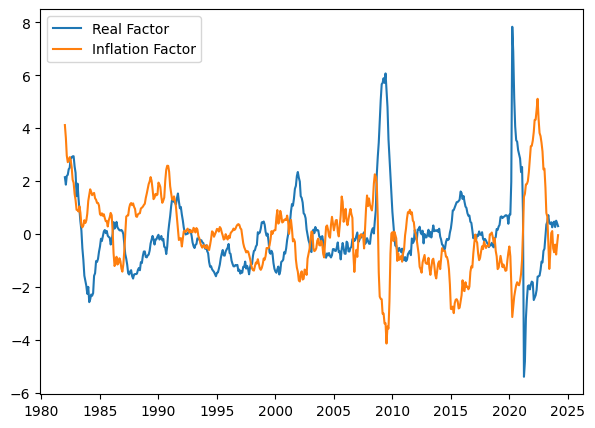

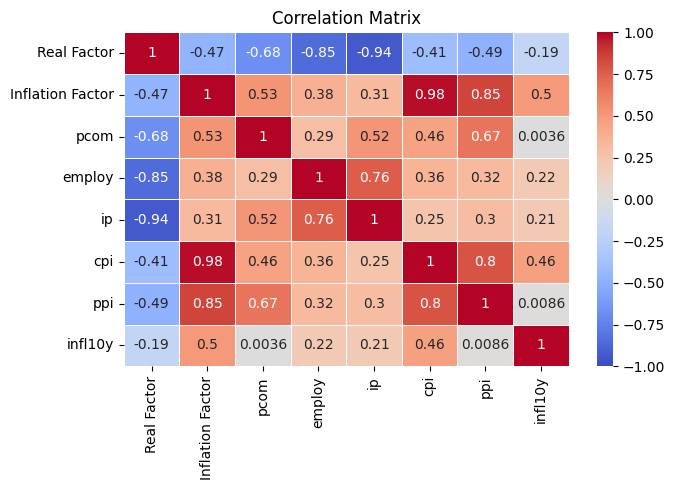

In [ ]:
# 3. PCA를 통한 실질 활동과 인플레이션 요인 추출
# 목적: PCA를 사용하여 실질 경제 변수와 인플레이션 변수에서 각각 1개의 주성분을 추출하고 요인을 데이터프레임으로 저장합니다.
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_data)
inflation_scaled = scaler.fit_transform(inflation_data)
pca_real = PCA(n_components=1)
real_factors = pca_real.fit_transform(real_scaled)
pca_inflation = PCA(n_components=1)
inflation_factors = pca_inflation.fit_transform(inflation_scaled)
real_factors_df = pd.DataFrame(real_factors, index=real_data.index, columns=['RealFactor'])
inflation_factors_df = pd.DataFrame(inflation_factors, index=inflation_data.index, columns=['InflationFactor'])
print("실질 요인의 설명력: ", pca_real.explained_variance_ratio_[0])
print("인플레이션 요인의 설명력: ", pca_inflation.explained_variance_ratio_[0])
print("실질 요인과 원래 변수들의 상관관계:\n", pca_real.components_)
print("인플레이션 요인과 원래 변수들의 상관관계:\n", pca_inflation.components_)

graph_data = pd.concat([real_factors_df, inflation_factors_df], axis=1)
graph_data.columns = ['Real Factor', 'Inflation Factor']
graph_data.to_excel('factor_graph_data.xlsx', index=True)
plt.figure(figsize=(7, 5))
plt.plot(graph_data['Real Factor'], label='Real Factor')
plt.plot(graph_data['Inflation Factor'], label='Inflation Factor')
plt.legend()
plt.show()

factors_data = pd.concat([real_factors_df, inflation_factors_df, real_data, inflation_data], axis=1)
factors_data.columns = ['Real Factor', 'Inflation Factor'] + real_cols + inflation_cols
corr_matrix = factors_data.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# 4. 상태 공간 모형 설정 및 추정
# 목적: DNS 요인, 실질 활동 요인, 인플레이션 요인, 연방기금실효금리를 상태 변수로 포함하여 VAR 및 VEC 모형을 설정하고 추정합니다.
state_variables = pd.concat([dns_factors, real_factors_df, inflation_factors_df, ffer_data], axis=1)
observation_variables = treasury_data

In [ ]:
# 5. 단위근 검정 및 공적분 검정
# 목적: ADF 검정을 사용하여 변수들의 단위근 검정을 수행하고 Engle-Granger 및 Johansen 공적분 검정을 수행합니다.
def adf_test(timeseries, name=None):
    if name is None:
        print('Results of ADF Test')
    else:
        print(f'Results of ADF Test for {name}')
    adf_test = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'   {key}, {value}')
    print('-'*30)

def eg_coint_test(y, x):
    y = np.asarray(y)
    x = np.asarray(x)
    res_ols = np.polyfit(x, y, 1)
    y_hat = np.polyval(res_ols, x)
    u_hat = y - y_hat
    adf_test(u_hat)

def johansen_coint_test(y, x):
    print('Results of Johansen Cointegration Test')
    res = coint_johansen(np.array([y, x]).T, det_order=0, k_ar_diff=1)
    print('Eigenvalues:', res.eig)
    print('Critical values (90%, 95%, 99%):', res.cvt)
    print('Trace statistic:', res.lr1)
    print('Max-eigen statistic:', res.lr2)
    print('-'*30)

adf_test(observation_variables['govt12m'], name='govt12m')
for col in state_variables.columns:
    adf_test(state_variables[col], name=col)

eg_coint_test(observation_variables['govt12m'], state_variables['Level'])
eg_coint_test(observation_variables['govt12m'], state_variables['Slope'])
eg_coint_test(observation_variables['govt12m'], state_variables['Curvature'])
eg_coint_test(observation_variables['govt12m'], state_variables['RealFactor'])
eg_coint_test(observation_variables['govt12m'], state_variables['InflationFactor'])
eg_coint_test(observation_variables['govt12m'], state_variables['ffer'])

johansen_coint_test(observation_variables['govt12m'], state_variables['Level'])
johansen_coint_test(observation_variables['govt12m'], state_variables['Slope'])
johansen_coint_test(observation_variables['govt12m'], state_variables['Curvature'])
johansen_coint_test(observation_variables['govt12m'], state_variables['RealFactor'])
johansen_coint_test(observation_variables['govt12m'], state_variables['InflationFactor'])
johansen_coint_test(observation_variables['govt12m'], state_variables['ffer'])

Results of ADF Test for govt12m
ADF Statistic: -2.124586165783405
p-value: 0.23474397899750843
Critical Values:
   1%, -3.4437660979098843
   5%, -2.8674565460819896
   10%, -2.569921291128696
------------------------------
Results of ADF Test for Level
ADF Statistic: -2.7960312730433228
p-value: 0.05884291256356124
Critical Values:
   1%, -3.443470002903981
   5%, -2.867326248740681
   10%, -2.569851849873108
------------------------------
Results of ADF Test for Slope
ADF Statistic: -1.5232104084426803
p-value: 0.521999838511472
Critical Values:
   1%, -3.443339692005083
   5%, -2.8672689011327894
   10%, -2.569821287318971
------------------------------
Results of ADF Test for Curvature
ADF Statistic: -2.3753896513351513
p-value: 0.1488033033954521
Critical Values:
   1%, -3.443339692005083
   5%, -2.8672689011327894
   10%, -2.569821287318971
------------------------------
Results of ADF Test for RealFactor
ADF Statistic: -4.993982052008694
p-value: 2.2809897687462265e-05
Critical 

In [ ]:
# 목적: ADF 검정과 KPSS 검정을 사용하여 변수들의 단위근 검정을 수행합니다.
def check_stationarity(series, sig_level=0.05, print_res=True):
    adf_result = adfuller(series)
    kpss_result = kpss(series)
    if print_res:
        print(f'ADF Test p-value: {adf_result[1]}')
        print(f'KPSS Test p-value: {kpss_result[1]}')
    if adf_result[1] < sig_level and kpss_result[1] > sig_level:
        return True
    else:
        return False

# 각 변수의 안정성 확인
var_data = pd.concat([treasury_data, dns_factors, real_factors_df, inflation_factors_df, ffer_data], axis=1)
for col in var_data.columns:
    is_stationary = check_stationarity(var_data[col])
    print(f'{col}: Stationary - {is_stationary}')

ADF Test p-value: 0.23474397899750843
KPSS Test p-value: 0.01
govt12m: Stationary - False
ADF Test p-value: 0.04256126570216564
KPSS Test p-value: 0.01
govt36m: Stationary - False
ADF Test p-value: 0.05833847795542015
KPSS Test p-value: 0.01
govt60m: Stationary - False
ADF Test p-value: 0.08861143723136938
KPSS Test p-value: 0.01
govt120m: Stationary - False
ADF Test p-value: 0.05884291256356124
KPSS Test p-value: 0.01
Level: Stationary - False
ADF Test p-value: 0.521999838511472
KPSS Test p-value: 0.01
Slope: Stationary - False
ADF Test p-value: 0.1488033033954521
KPSS Test p-value: 0.01829159270970586
Curvature: Stationary - False
ADF Test p-value: 2.2809897687462265e-05
KPSS Test p-value: 0.1
RealFactor: Stationary - True
ADF Test p-value: 0.0006729771552868469
KPSS Test p-value: 0.014851439574494177
InflationFactor: Stationary - False
ADF Test p-value: 0.01589460131708619
KPSS Test p-value: 0.01
ffer: Stationary - False


<ipython-input-11-372a9545b32e>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series)
<ipython-input-11-372a9545b32e>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series)
<ipython-input-11-372a9545b32e>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series)
<ipython-input-11-372a9545b32e>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series)
<ipython-input-11-372a9545b32e>:4: InterpolationWarning: The test statistic 

In [ ]:
# 5-1. VAR 모형
var_data = pd.concat([observation_variables, state_variables], axis=1)
var_data_diff = var_data.diff().dropna()

# 추가: VAR 모형의 최적 시차 선택
var_model = VAR(var_data_diff)
lag_order = var_model.select_order(maxlags=10)
print("Optimal Lag Order (VAR):")
print(lag_order.summary())
aic_lag_diff = lag_order.aic

var_results = var_model.fit(maxlags=aic_lag_diff)

# 5-2. VECM 모형
from statsmodels.tsa.vector_ar.vecm import coint_johansen
vecm_data = pd.concat([observation_variables, state_variables], axis=1)

# Johansen 공적분 검정 수행
coint_test = coint_johansen(vecm_data, det_order=-1, k_ar_diff=4)  # k_ar_diff는 시차 수
# 공적분 순위 추정
coint_rank = sum(coint_test.lr1 > coint_test.cvt[:, 1])  # 0.05 significance level
# 결과 출력
print("Johansen Cointegration Test Results:")
print("Test Statistic Values:", coint_test.lr1)
print("Critical Values (5%):", coint_test.cvt[:, 1])  # 0.05 significance level
print("Eigenvalues:", coint_test.eig)
print("Recommended Cointegration Rank:", coint_rank)
# VECM 모델 피팅 및 요약
vecm_results = VECM(vecm_data, k_ar_diff=4, coint_rank=coint_rank).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimal Lag Order (VAR):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -33.32     -33.24*   3.374e-15      -33.29
1      -34.10*      -33.17  1.544e-15*     -33.74*
2       -34.00      -32.22   1.720e-15      -33.30
3       -33.86      -31.23   1.977e-15      -32.83
4       -33.78      -30.30   2.145e-15      -32.41
5       -33.63      -29.31   2.498e-15      -31.93
6       -33.43      -28.26   3.056e-15      -31.40
7       -33.29      -27.27   3.564e-15      -30.92
8       -33.09      -26.22   4.382e-15      -30.39
9       -32.98      -25.26   4.946e-15      -29.95
10      -32.87      -24.31   5.607e-15      -29.51
--------------------------------------------------
Johansen Cointegration Test Results:
Test Statistic Values: [316.14108853 229.48562099 161.600056   110.56862991  69.63564094
  41.32057524  25.04700092  13.80494928   4.90115885   1.86106571]
Critical Values (

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# 6. 모형 진단 및 평가
# 목적: 추정된 모형의 적합도를 평가하고 잔차 분석 등을 수행합니다.
print("VAR Model Results:")
print(var_results.summary())
print("VECM Model Results:")
print(vecm_results.summary())

VAR Model Results:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, May, 2024
Time:                     13:45:45
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -32.3377
Nobs:                     505.000    HQIC:                  -32.8969
Log likelihood:           1341.97    FPE:                3.60021e-15
AIC:                     -33.2579    Det(Omega_mle):     2.90232e-15
--------------------------------------------------------------------
Results for equation govt12m
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.008118         0.010392           -0.781           0.435
L1.govt12m                -0.312882         0.202601           -1.544           0.123
L1.govt36m         

In [ ]:
# 최적 시차 결정
var_model = VAR(var_data_diff)
lag_order = var_model.select_order(maxlags=10)
aic_lag = lag_order.aic

print("Optimal Lag Order (VAR):")
print(lag_order.summary())

# Granger 인과관계 검정에 사용될 maxlag 설정
maxlag = aic_lag

Optimal Lag Order (VAR):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -33.32     -33.24*   3.374e-15      -33.29
1      -34.10*      -33.17  1.544e-15*     -33.74*
2       -34.00      -32.22   1.720e-15      -33.30
3       -33.86      -31.23   1.977e-15      -32.83
4       -33.78      -30.30   2.145e-15      -32.41
5       -33.63      -29.31   2.498e-15      -31.93
6       -33.43      -28.26   3.056e-15      -31.40
7       -33.29      -27.27   3.564e-15      -30.92
8       -33.09      -26.22   4.382e-15      -30.39
9       -32.98      -25.26   4.946e-15      -29.95
10      -32.87      -24.31   5.607e-15      -29.51
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Granger 인과관계 검정에 사용될 maxlag 설정
maxlag = 1

# 7. 그랜저 인과관계 검정
print("Granger Causality Test Results:")
for col in var_data_diff.columns:
    for col2 in var_data_diff.columns:
        if col != col2:
            test_result = grangercausalitytests(var_data_diff[[col, col2]], maxlag=maxlag, verbose=False)
            print(f"Granger Causality Test between {col} and {col2} (Lag: {maxlag}):")
            for key, result in test_result.items():
                print(f'Lag {key}:', 'F-test p-value:', result[0]['ssr_ftest'][1])

Granger Causality Test Results:
Granger Causality Test between govt12m and govt36m (Lag: 1):
Lag 1: F-test p-value: 0.058167503022068814
Granger Causality Test between govt12m and govt60m (Lag: 1):
Lag 1: F-test p-value: 0.08548767012753213
Granger Causality Test between govt12m and govt120m (Lag: 1):
Lag 1: F-test p-value: 0.12355349746134399
Granger Causality Test between govt12m and Level (Lag: 1):
Lag 1: F-test p-value: 0.38167039022850135
Granger Causality Test between govt12m and Slope (Lag: 1):
Lag 1: F-test p-value: 0.558448745175796
Granger Causality Test between govt12m and Curvature (Lag: 1):
Lag 1: F-test p-value: 0.9133302098261271
Granger Causality Test between govt12m and RealFactor (Lag: 1):
Lag 1: F-test p-value: 0.6185115886660475
Granger Causality Test between govt12m and InflationFactor (Lag: 1):
Lag 1: F-test p-value: 0.11523847663998389
Granger Causality Test between govt12m and ffer (Lag: 1):
Lag 1: F-test p-value: 0.05379399453353954
Granger Causality Test betwe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

Granger Causality Test between govt60m and Slope (Lag: 1):
Lag 1: F-test p-value: 0.2479241532327498
Granger Causality Test between govt60m and Curvature (Lag: 1):
Lag 1: F-test p-value: 0.17801327340668177
Granger Causality Test between govt60m and RealFactor (Lag: 1):
Lag 1: F-test p-value: 0.437862909896629
Granger Causality Test between govt60m and InflationFactor (Lag: 1):
Lag 1: F-test p-value: 0.11305351860159844
Granger Causality Test between govt60m and ffer (Lag: 1):
Lag 1: F-test p-value: 0.35849689657880024
Granger Causality Test between govt120m and govt12m (Lag: 1):
Lag 1: F-test p-value: 0.9221228002614686
Granger Causality Test between govt120m and govt36m (Lag: 1):
Lag 1: F-test p-value: 0.35703985592942966
Granger Causality Test between govt120m and govt60m (Lag: 1):
Lag 1: F-test p-value: 0.3662694949188583
Granger Causality Test between govt120m and Level (Lag: 1):
Lag 1: F-test p-value: 0.791196274033637
Granger Causality Test between govt120m and Slope (Lag: 1):
L

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

Granger Causality Test between Level and Curvature (Lag: 1):
Lag 1: F-test p-value: 0.5408136887057655
Granger Causality Test between Level and RealFactor (Lag: 1):
Lag 1: F-test p-value: 0.1433841839273309
Granger Causality Test between Level and InflationFactor (Lag: 1):
Lag 1: F-test p-value: 0.7238949579477342
Granger Causality Test between Level and ffer (Lag: 1):
Lag 1: F-test p-value: 0.30038398270505995
Granger Causality Test between Slope and govt12m (Lag: 1):
Lag 1: F-test p-value: 0.459458477805451
Granger Causality Test between Slope and govt36m (Lag: 1):
Lag 1: F-test p-value: 0.8273158009316686
Granger Causality Test between Slope and govt60m (Lag: 1):
Lag 1: F-test p-value: 0.7688447073014453
Granger Causality Test between Slope and govt120m (Lag: 1):
Lag 1: F-test p-value: 0.2564332576692799
Granger Causality Test between Slope and Level (Lag: 1):
Lag 1: F-test p-value: 0.8852228598839421
Granger Causality Test between Slope and Curvature (Lag: 1):
Lag 1: F-test p-value

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

Granger Causality Test between RealFactor and ffer (Lag: 1):
Lag 1: F-test p-value: 0.1429378665025894
Granger Causality Test between InflationFactor and govt12m (Lag: 1):
Lag 1: F-test p-value: 0.00967010101053157
Granger Causality Test between InflationFactor and govt36m (Lag: 1):
Lag 1: F-test p-value: 0.0029564295718986803
Granger Causality Test between InflationFactor and govt60m (Lag: 1):
Lag 1: F-test p-value: 0.013518683100865868
Granger Causality Test between InflationFactor and govt120m (Lag: 1):
Lag 1: F-test p-value: 0.13828049517037838
Granger Causality Test between InflationFactor and Level (Lag: 1):
Lag 1: F-test p-value: 0.044438891516677834
Granger Causality Test between InflationFactor and Slope (Lag: 1):
Lag 1: F-test p-value: 0.7183590036476961
Granger Causality Test between InflationFactor and Curvature (Lag: 1):
Lag 1: F-test p-value: 0.35743815968239023
Granger Causality Test between InflationFactor and RealFactor (Lag: 1):
Lag 1: F-test p-value: 0.00098495920968

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

In [ ]:
# 8. 예측오차 분산분해
print("Forecast Error Variance Decomposition (VAR):")
var_fevd = var_results.fevd(10)
var_fevd.summary()

Forecast Error Variance Decomposition (VAR):
FEVD for govt12m
      govt12m   govt36m   govt60m  govt120m     Level     Slope  Curvature  RealFactor  InflationFactor      ffer
0    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000    0.000000         0.000000  0.000000
1    0.966603  0.006103  0.000269  0.002343  0.001467  0.001140   0.000193    0.000276         0.002235  0.019371
2    0.959914  0.008146  0.000695  0.003440  0.001606  0.001306   0.000201    0.000979         0.002539  0.021174
3    0.958328  0.008837  0.000808  0.003731  0.001663  0.001337   0.000202    0.001270         0.002597  0.021225
4    0.957905  0.009060  0.000831  0.003800  0.001677  0.001344   0.000202    0.001348         0.002619  0.021212
5    0.957795  0.009121  0.000836  0.003816  0.001681  0.001346   0.000203    0.001369         0.002626  0.021207
6    0.957768  0.009137  0.000838  0.003820  0.001682  0.001347   0.000203    0.001374         0.002628  0.021205
7    0.957762  0.009140  0

In [ ]:
# 9. VAR 모형 안정성 검토
root_table = var_results.roots
print("VAR Model Roots:")
print(root_table)
if np.all(np.abs(root_table) < 1):
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

VAR Model Roots:
[ 27.04461553-0.j         -22.25606787-0.j
   2.50594525+7.08572835j   2.50594525-7.08572835j
   5.87396962-0.j           2.17545952+5.00102524j
   2.17545952-5.00102524j   3.00098967-0.j
   2.28752417+0.26740503j   2.28752417-0.26740503j]
The VAR model is not stable.


Shape of cointegration vectors: (3, 10)
Number of variables: 10


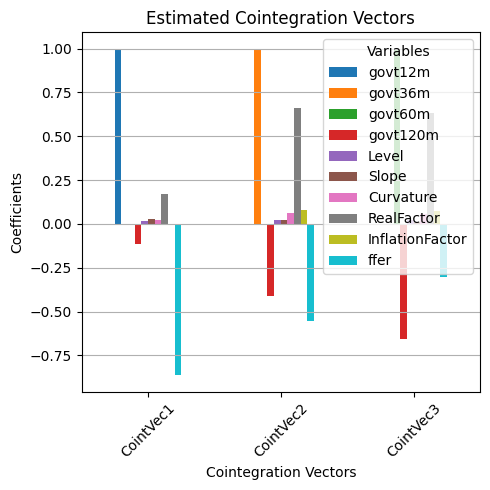

In [ ]:
# 10. 공적분 벡터의 추정치 가져오기
coint_vectors = vecm_results.beta.T
print("Shape of cointegration vectors:", coint_vectors.shape)
print("Number of variables:", len(vecm_data.columns))

num_vars = len(vecm_data.columns)
num_coint_vecs = coint_vectors.shape[0]
coint_df = pd.DataFrame(coint_vectors, index=[f'CointVec{i+1}' for i in range(num_coint_vecs)], columns=vecm_data.columns[:num_vars])

coint_df.plot(kind='bar', figsize=(5, 5), rot=45)
plt.title('Estimated Cointegration Vectors')
plt.xlabel('Cointegration Vectors')
plt.ylabel('Coefficients')
plt.legend(title='Variables')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

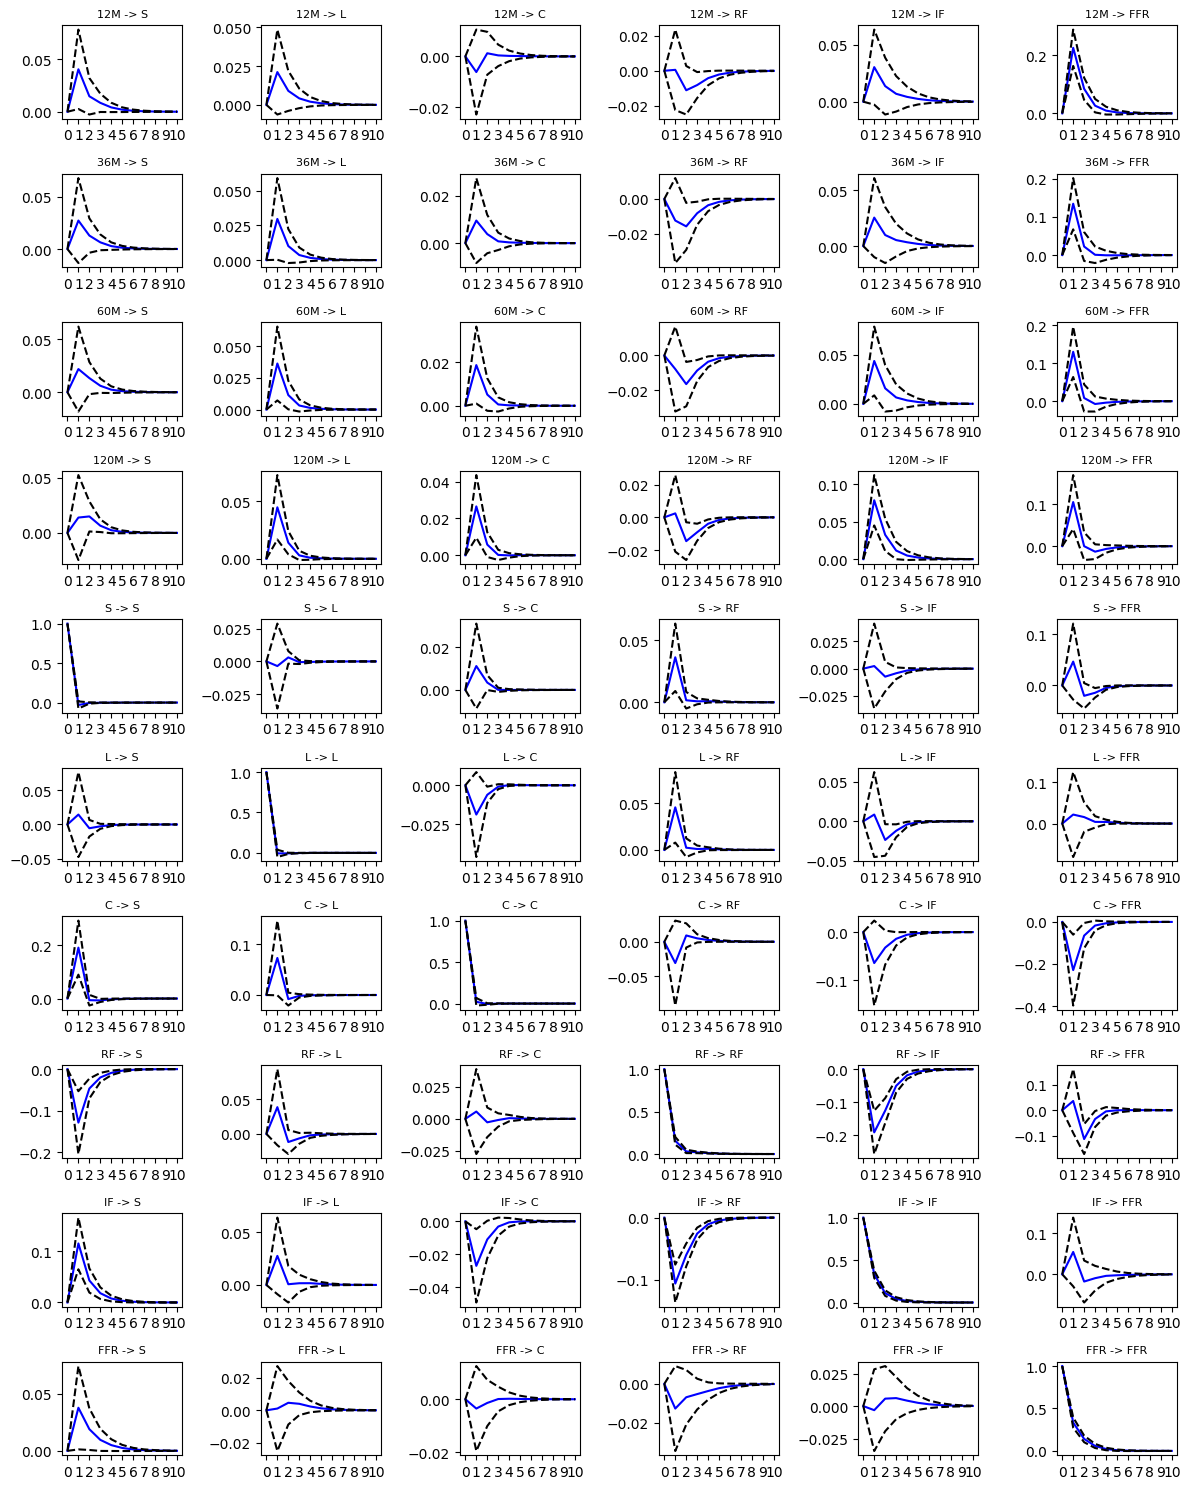

In [ ]:
# 11. 충격반응분석을 위한 VAR 모형 결과 시각화
var_irf = var_results.irf(periods=10)

# 그래프 크기 설정: 10행 6열
fig, axs = plt.subplots(10, 6, figsize=(12, 15))

# 그래프 축 설정
x = np.arange(0, 11)  # 가로축 값 (0부터 10까지)

# 그래프 제목 변경을 위한 딕셔너리
title_dict = {
    'govt12m': '12M',
    'govt36m': '36M',
    'govt60m': '60M',
    'govt120m': '120M',
    'Slope': 'S',
    'Level': 'L',
    'Curvature': 'C',
    'RealFactor': 'RF',
    'InflationFactor': 'IF',
    'ffer': 'FFR'
}

# VAR 모형 충격반응분석 결과 시각화
var_irf_data = var_irf.irfs
var_irf_conf_int = var_irf.stderr()  # 신뢰구간을 위해 표준오차 가져오기

# 오른쪽 6열만 선택
right_col_indices = range(4, 10)

for i in range(10):  # 행
    for j, col in enumerate(right_col_indices):  # 열
        axs[i, j].plot(x, var_irf_data[:, i, col], color='blue')  # 중앙선
        axs[i, j].plot(x, var_irf_data[:, i, col] + var_irf_conf_int[:, i, col], color='black', linestyle='dashed')  # 위 점선
        axs[i, j].plot(x, var_irf_data[:, i, col] - var_irf_conf_int[:, i, col], color='black', linestyle='dashed')  # 아래 점선
        axs[i, j].set_title(f"{list(title_dict.values())[i]} -> {list(title_dict.values())[col]}", fontsize=8)
        axs[i, j].set_xticks(x)

plt.tight_layout()
# plt.suptitle('VAR Impulse Response Functions (Right 6 Columns)', fontsize=12)  # suptitle을 제거함
plt.show()

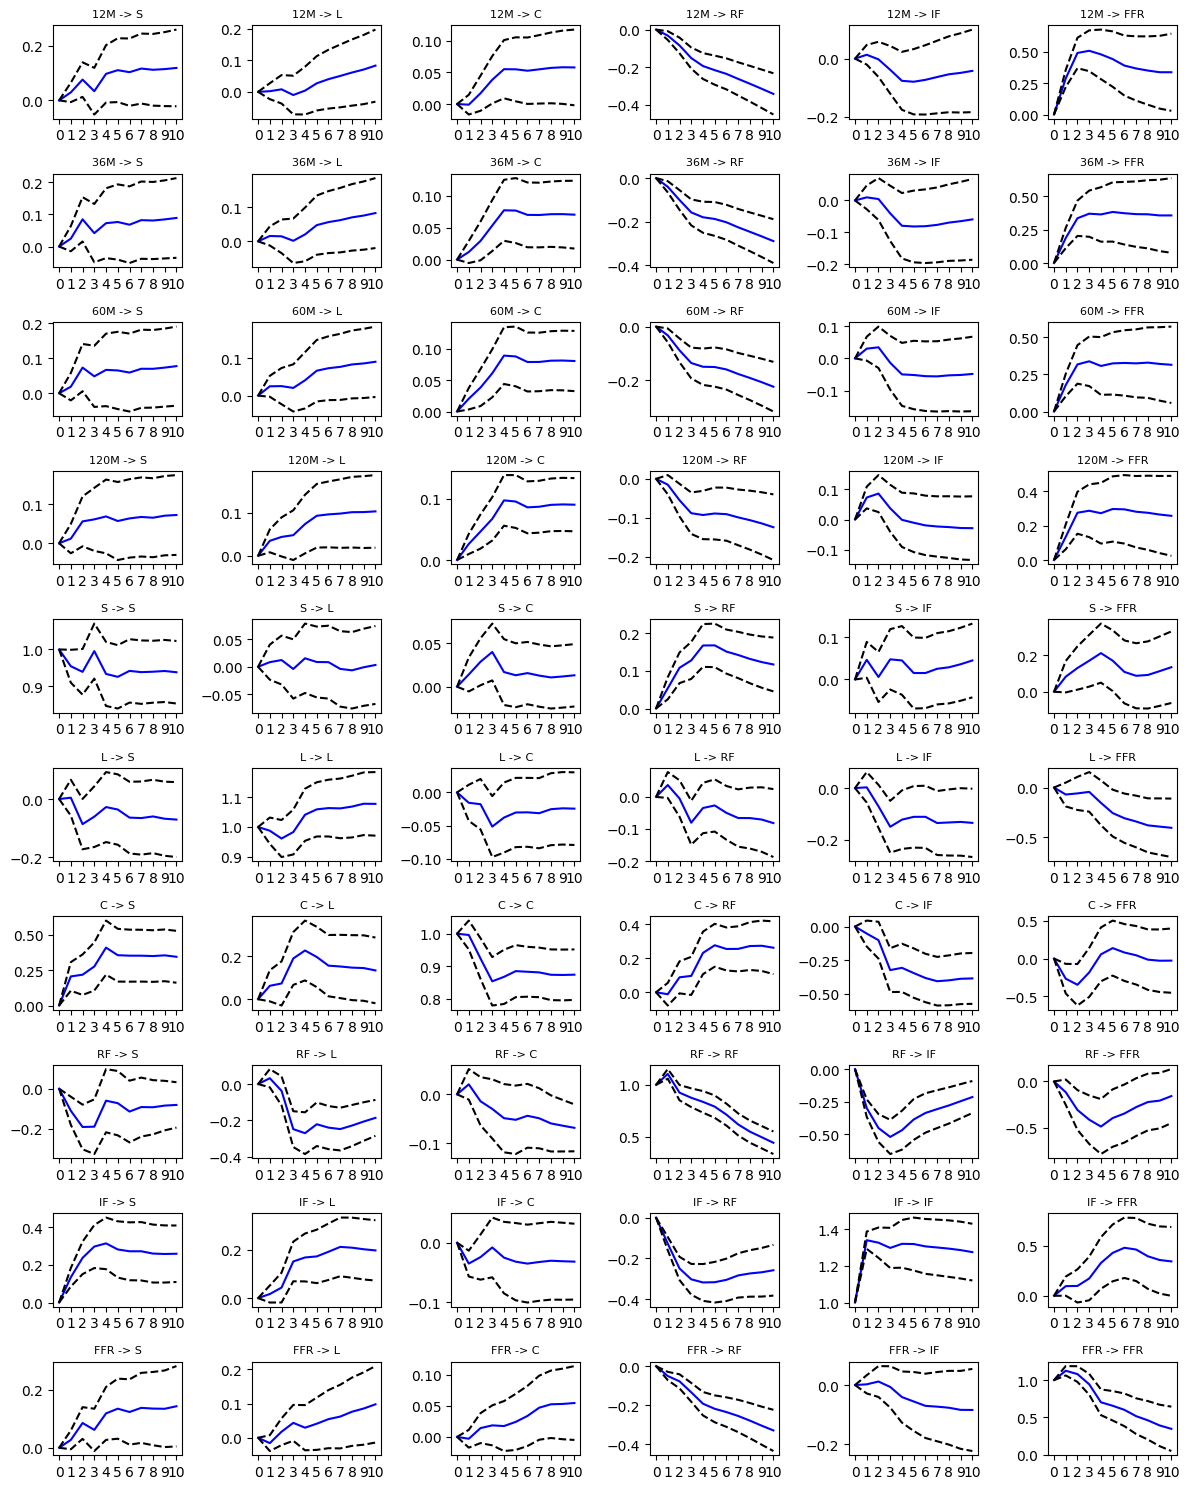

In [ ]:
# 12. 충격반응분석을 위한 VECM 모형 결과 시각화
vecm_irf = vecm_results.irf(periods=10)

# 그래프 크기 설정: 10행 6열
fig, axs = plt.subplots(10, 6, figsize=(12, 15))

# 그래프 축 설정
x = np.arange(0, 11)  # 가로축 값 (0부터 10까지)

# 그래프 제목 변경을 위한 딕셔너리
title_dict = {
    'govt12m': '12M',
    'govt36m': '36M',
    'govt60m': '60M',
    'govt120m': '120M',
    'Slope': 'S',
    'Level': 'L',
    'Curvature': 'C',
    'RealFactor': 'RF',
    'InflationFactor': 'IF',
    'ffer': 'FFR'
}

# VECM 모형 충격반응분석 결과 시각화
vecm_irf_data = vecm_irf.irfs
vecm_irf_conf_int = vecm_irf.stderr()  # 신뢰구간을 위해 표준오차 가져오기

# 오른쪽 6열만 선택
right_col_indices = range(4, 10)

for i in range(10):  # 행
    for j, col in enumerate(right_col_indices):  # 열
        axs[i, j].plot(x, vecm_irf_data[:, i, col], color='blue')  # 중앙선
        axs[i, j].plot(x, vecm_irf_data[:, i, col] + vecm_irf_conf_int[:, i, col], color='black', linestyle='dashed')  # 위 점선
        axs[i, j].plot(x, vecm_irf_data[:, i, col] - vecm_irf_conf_int[:, i, col], color='black', linestyle='dashed')  # 아래 점선
        axs[i, j].set_title(f"{list(title_dict.values())[i]} -> {list(title_dict.values())[col]}", fontsize=8)
        axs[i, j].set_xticks(x)

plt.tight_layout()
plt.show()


In [ ]:
# 14. 예측 성과 평가 (DNS+거시경제, DNS Only, 거시경제 Only)
# 목적: 각 모형의 예측 성과를 평가하기 위해 표본 외 예측을 수행하고 RMSE, MAE, MAPE 등의 지표를 계산합니다.
nobs = 12

# 14.1 DNS+거시경제 모형
var_forecast_combined = var_results.forecast(y=var_results.endog[-nobs:], steps=nobs)
var_forecast_combined_df = pd.DataFrame(var_forecast_combined, index=observation_variables.index[-nobs:], columns=var_results.names)
vecm_forecast_combined = vecm_results.predict(steps=nobs)
vecm_forecast_combined_df = pd.DataFrame(vecm_forecast_combined, index=observation_variables.index[-nobs:], columns=vecm_data.columns)

var_rmse_combined = np.sqrt(mean_squared_error(observation_variables.iloc[-nobs:], var_forecast_combined_df.iloc[:, :4]))
var_mae_combined = mean_absolute_error(observation_variables.iloc[-nobs:], var_forecast_combined_df.iloc[:, :4])
var_mape_combined = mean_absolute_percentage_error(observation_variables.iloc[-nobs:], var_forecast_combined_df.iloc[:, :4])
vecm_rmse_combined = np.sqrt(mean_squared_error(observation_variables.iloc[-nobs:], vecm_forecast_combined_df.iloc[:, :4]))
vecm_mae_combined = mean_absolute_error(observation_variables.iloc[-nobs:], vecm_forecast_combined_df.iloc[:, :4])
vecm_mape_combined = mean_absolute_percentage_error(observation_variables.iloc[-nobs:], vecm_forecast_combined_df.iloc[:, :4])

print(f"DNS+거시경제 VAR Forecast RMSE: {var_rmse_combined:.4f}, MAE: {var_mae_combined:.4f}, MAPE: {var_mape_combined:.4f}")
print(f"DNS+거시경제 VECM Forecast RMSE: {vecm_rmse_combined:.4f}, MAE: {vecm_mae_combined:.4f}, MAPE: {vecm_mape_combined:.4f}")

DNS+거시경제 VAR Forecast RMSE: 4.4277, MAE: 4.3986, MAPE: 1.0024
DNS+거시경제 VECM Forecast RMSE: 0.5501, MAE: 0.4447, MAPE: 0.0990


In [ ]:
# 14.2 DNS Only 모형
# 14.2.1 DNS Only 모형 중 VAR 모형
dns_var_data = pd.concat([observation_variables, dns_factors], axis=1)
dns_var_model = VAR(dns_var_data)
dns_var_results = dns_var_model.fit(maxlags=1)

dns_var_forecast = dns_var_results.forecast(y=dns_var_results.endog[-nobs:], steps=nobs)
dns_var_forecast_df = pd.DataFrame(dns_var_forecast, index=observation_variables.index[-nobs:], columns=dns_var_results.names)

dns_var_rmse = np.sqrt(mean_squared_error(observation_variables.iloc[-nobs:], dns_var_forecast_df.iloc[:, :4]))
dns_var_mae = mean_absolute_error(observation_variables.iloc[-nobs:], dns_var_forecast_df.iloc[:, :4])
dns_var_mape = mean_absolute_percentage_error(observation_variables.iloc[-nobs:], dns_var_forecast_df.iloc[:, :4])

print(f"DNS-VAR Forecast RMSE: {dns_var_rmse:.4f}, MAE: {dns_var_mae:.4f}, MAPE: {dns_var_mape:.4f}")

# 14.2.2 DNS Only 모형 중 VEC 모형
dns_vecm_data = pd.concat([observation_variables, dns_factors], axis=1)
dns_vecm_model = VECM(dns_vecm_data, k_ar_diff=1, coint_rank=1)
dns_vecm_results = dns_vecm_model.fit()

dns_vecm_forecast = dns_vecm_results.predict(steps=nobs)
dns_vecm_forecast_df = pd.DataFrame(dns_vecm_forecast, index=observation_variables.index[-nobs:], columns=dns_vecm_data.columns)

dns_vecm_rmse = np.sqrt(mean_squared_error(observation_variables.iloc[-nobs:], dns_vecm_forecast_df.iloc[:, :4]))
dns_vecm_mae = mean_absolute_error(observation_variables.iloc[-nobs:], dns_vecm_forecast_df.iloc[:, :4])
dns_vecm_mape = mean_absolute_percentage_error(observation_variables.iloc[-nobs:], dns_vecm_forecast_df.iloc[:, :4])

print(f"DNS-VECM Forecast RMSE: {dns_vecm_rmse:.4f}, MAE: {dns_vecm_mae:.4f}, MAPE: {dns_vecm_mape:.4f}")

DNS-VAR Forecast RMSE: 0.4164, MAE: 0.3451, MAPE: 0.0783
DNS-VECM Forecast RMSE: 0.3454, MAE: 0.2882, MAPE: 0.0689


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# 14.3 거시경제 Only 모형

# 거시경제 요인 데이터 통합
macro_factors = pd.concat([real_factors_df, inflation_factors_df, ffer_data], axis=1)

# 14.3.1 VAR 모형
macro_var_data = pd.concat([observation_variables, macro_factors], axis=1)
macro_var_model = VAR(macro_var_data)
macro_var_results = macro_var_model.fit(maxlags=1)

macro_var_forecast = macro_var_results.forecast(y=macro_var_results.endog[-nobs:], steps=nobs)
macro_var_forecast_df = pd.DataFrame(macro_var_forecast, index=observation_variables.index[-nobs:], columns=macro_var_results.names)

macro_var_rmse = np.sqrt(mean_squared_error(observation_variables.iloc[-nobs:], macro_var_forecast_df.iloc[:, :4]))
macro_var_mae = mean_absolute_error(observation_variables.iloc[-nobs:], macro_var_forecast_df.iloc[:, :4])
macro_var_mape = mean_absolute_percentage_error(observation_variables.iloc[-nobs:], macro_var_forecast_df.iloc[:, :4])

print(f"Macro-VAR Forecast RMSE: {macro_var_rmse:.4f}, MAE: {macro_var_mae:.4f}, MAPE: {macro_var_mape:.4f}")

# 14.3.2 VEC 모형
macro_vecm_data = pd.concat([observation_variables, macro_factors], axis=1)
macro_vecm_model = VECM(macro_vecm_data, k_ar_diff=1, coint_rank=1)
macro_vecm_results = macro_vecm_model.fit()

macro_vecm_forecast = macro_vecm_results.predict(steps=nobs)
macro_vecm_forecast_df = pd.DataFrame(macro_vecm_forecast, index=observation_variables.index[-nobs:], columns=macro_vecm_data.columns)

macro_vecm_rmse = np.sqrt(mean_squared_error(observation_variables.iloc[-nobs:], macro_vecm_forecast_df.iloc[:, :4]))
macro_vecm_mae = mean_absolute_error(observation_variables.iloc[-nobs:], macro_vecm_forecast_df.iloc[:, :4])
macro_vecm_mape = mean_absolute_percentage_error(observation_variables.iloc[-nobs:], macro_vecm_forecast_df.iloc[:, :4])

print(f"Macro-VECM Forecast RMSE: {macro_vecm_rmse:.4f}, MAE: {macro_vecm_mae:.4f}, MAPE: {macro_vecm_mape:.4f}")

Macro-VAR Forecast RMSE: 0.5557, MAE: 0.4700, MAPE: 0.1047
Macro-VECM Forecast RMSE: 0.3369, MAE: 0.2793, MAPE: 0.0667


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# 13. 예측 성과 평가
# 목적: 모형의 예측 성과를 평가하기 위해 표본 외 예측을 수행하고 RMSE, MAE, MAPE 등의 지표를 계산합니다.

# 13.1 DNS+거시경제 모형
var_residuals_combined = var_results.resid
vecm_residuals_combined = vecm_results.resid

var_mse_combined = mean_squared_error(var_data.iloc[-len(var_residuals_combined):], var_data.iloc[-len(var_residuals_combined):] - var_residuals_combined)
var_mae_combined = mean_absolute_error(var_data.iloc[-len(var_residuals_combined):], var_data.iloc[-len(var_residuals_combined):] - var_residuals_combined)
var_mape_combined = mean_absolute_percentage_error(var_data.iloc[-len(var_residuals_combined):], var_data.iloc[-len(var_residuals_combined):] - var_residuals_combined)

vecm_mse_combined = mean_squared_error(vecm_data.iloc[-len(vecm_residuals_combined):], vecm_data.iloc[-len(vecm_residuals_combined):] - vecm_residuals_combined)
vecm_mae_combined = mean_absolute_error(vecm_data.iloc[-len(vecm_residuals_combined):], vecm_data.iloc[-len(vecm_residuals_combined):] - vecm_residuals_combined)
vecm_mape_combined = mean_absolute_percentage_error(vecm_data.iloc[-len(vecm_residuals_combined):], vecm_data.iloc[-len(vecm_residuals_combined):] - vecm_residuals_combined)

print(f"DNS+거시경제 VAR model - MSE: {var_mse_combined:.4f}, MAE: {var_mae_combined:.4f}, MAPE: {var_mape_combined:.4f}")
print(f"DNS+거시경제 VECM model - MSE: {vecm_mse_combined:.4f}, MAE: {vecm_mae_combined:.4f}, MAPE: {vecm_mape_combined:.4f}")

# 13.2 DNS Only 모형
dns_var_residuals = dns_var_results.resid
dns_vecm_residuals = dns_vecm_results.resid

dns_var_mse = mean_squared_error(dns_var_data.iloc[-len(dns_var_residuals):], dns_var_data.iloc[-len(dns_var_residuals):] - dns_var_residuals)
dns_var_mae = mean_absolute_error(dns_var_data.iloc[-len(dns_var_residuals):], dns_var_data.iloc[-len(dns_var_residuals):] - dns_var_residuals)
dns_var_mape = mean_absolute_percentage_error(dns_var_data.iloc[-len(dns_var_residuals):], dns_var_data.iloc[-len(dns_var_residuals):] - dns_var_residuals)

dns_vecm_mse = mean_squared_error(dns_vecm_data.iloc[-len(dns_vecm_residuals):], dns_vecm_data.iloc[-len(dns_vecm_residuals):] - dns_vecm_residuals)
dns_vecm_mae = mean_absolute_error(dns_vecm_data.iloc[-len(dns_vecm_residuals):], dns_vecm_data.iloc[-len(dns_vecm_residuals):] - dns_vecm_residuals)
dns_vecm_mape = mean_absolute_percentage_error(dns_vecm_data.iloc[-len(dns_vecm_residuals):], dns_vecm_data.iloc[-len(dns_vecm_residuals):] - dns_vecm_residuals)

print(f"DNS Only VAR model - MSE: {dns_var_mse:.4f}, MAE: {dns_var_mae:.4f}, MAPE: {dns_var_mape:.4f}")
print(f"DNS Only VECM model - MSE: {dns_vecm_mse:.4f}, MAE: {dns_vecm_mae:.4f}, MAPE: {dns_vecm_mape:.4f}")

# 13.3 거시경제 Only 모형
macro_var_residuals = macro_var_results.resid
macro_vecm_residuals = macro_vecm_results.resid

macro_var_mse = mean_squared_error(macro_var_data.iloc[-len(macro_var_residuals):], macro_var_data.iloc[-len(macro_var_residuals):] - macro_var_residuals)
macro_var_mae = mean_absolute_error(macro_var_data.iloc[-len(macro_var_residuals):], macro_var_data.iloc[-len(macro_var_residuals):] - macro_var_residuals)
macro_var_mape = mean_absolute_percentage_error(macro_var_data.iloc[-len(macro_var_residuals):], macro_var_data.iloc[-len(macro_var_residuals):] - macro_var_residuals)

macro_vecm_mse = mean_squared_error(macro_vecm_data.iloc[-len(macro_vecm_residuals):], macro_vecm_data.iloc[-len(macro_vecm_residuals):] - macro_vecm_residuals)
macro_vecm_mae = mean_absolute_error(macro_vecm_data.iloc[-len(macro_vecm_residuals):], macro_vecm_data.iloc[-len(macro_vecm_residuals):] - macro_vecm_residuals)
macro_vecm_mape = mean_absolute_percentage_error(macro_vecm_data.iloc[-len(macro_vecm_residuals):], macro_vecm_data.iloc[-len(macro_vecm_residuals):] - macro_vecm_residuals)

print(f"거시경제 Only VAR model - MSE: {macro_var_mse:.4f}, MAE: {macro_var_mae:.4f}, MAPE: {macro_var_mape:.4f}")
print(f"거시경제 Only VECM model - MSE: {macro_vecm_mse:.4f}, MAE: {macro_vecm_mae:.4f}, MAPE: {macro_vecm_mape:.4f}")

DNS+거시경제 VAR model - MSE: 0.1172, MAE: 0.2283, MAPE: 0.9783
DNS+거시경제 VECM model - MSE: 0.1053, MAE: 0.2206, MAPE: 0.8736
DNS Only VAR model - MSE: 0.1224, MAE: 0.2521, MAPE: 0.3928
DNS Only VECM model - MSE: 0.1184, MAE: 0.2460, MAPE: 0.4025
거시경제 Only VAR model - MSE: 0.0914, MAE: 0.1887, MAPE: 0.8660
거시경제 Only VECM model - MSE: 0.0812, MAE: 0.1819, MAPE: 1.0179


In [ ]:
# 17. 각 모형의 표본 내외 예측력 평가
# 목적: DNS+거시경제 결합 모형, DNS Only 모형, 거시경제 Only 모형의 예측력을 RMSE, MAE 등의 지표로 평가합니다.

# 17.1 DNS+거시경제 결합 모형 (VAR)
print("DNS+거시경제 결합 모형 (VAR) In-sample Forecast Evaluation:")
in_sample_rmse_combined_var = np.sqrt(mean_squared_error(var_data.iloc[-len(var_results.fittedvalues):], var_results.fittedvalues))
in_sample_mae_combined_var = mean_absolute_error(var_data.iloc[-len(var_results.fittedvalues):], var_results.fittedvalues)
print(f"In-sample RMSE: {in_sample_rmse_combined_var:.4f}")
print(f"In-sample MAE: {in_sample_mae_combined_var:.4f}")

print("DNS+거시경제 결합 모형 (VAR) Out-of-sample Forecast Evaluation (1-step ahead):")
out_sample_forecast_combined_var_1 = var_results.forecast(var_data.values[-1:], 1)
out_sample_rmse_combined_var_1 = np.sqrt(mean_squared_error(var_data.iloc[-1:], out_sample_forecast_combined_var_1))
out_sample_mae_combined_var_1 = mean_absolute_error(var_data.iloc[-1:], out_sample_forecast_combined_var_1)
print(f"1-step ahead RMSE: {out_sample_rmse_combined_var_1:.4f}")
print(f"1-step ahead MAE: {out_sample_mae_combined_var_1:.4f}")

print("DNS+거시경제 결합 모형 (VAR) Out-of-sample Forecast Evaluation (4-step ahead):")
out_sample_forecast_combined_var_4 = var_results.forecast_interval(var_data.values[-4:], 4)
out_sample_rmse_combined_var_4 = np.sqrt(mean_squared_error(var_data.iloc[-4:], out_sample_forecast_combined_var_4[0]))
out_sample_mae_combined_var_4 = mean_absolute_error(var_data.iloc[-4:], out_sample_forecast_combined_var_4[0])
print(f"4-step ahead RMSE: {out_sample_rmse_combined_var_4:.4f}")
print(f"4-step ahead MAE: {out_sample_mae_combined_var_4:.4f}")

print("DNS+거시경제 결합 모형 (VAR) Out-of-sample Forecast Evaluation (12-step ahead):")
out_sample_forecast_combined_var_12 = var_results.forecast_interval(var_data.values[-12:], 12)
out_sample_rmse_combined_var_12 = np.sqrt(mean_squared_error(var_data.iloc[-12:], out_sample_forecast_combined_var_12[0]))
out_sample_mae_combined_var_12 = mean_absolute_error(var_data.iloc[-12:], out_sample_forecast_combined_var_12[0])
print(f"12-step ahead RMSE: {out_sample_rmse_combined_var_12:.4f}")
print(f"12-step ahead MAE: {out_sample_mae_combined_var_12:.4f}")

DNS+거시경제 결합 모형 (VAR) In-sample Forecast Evaluation:
In-sample RMSE: 4.2144
In-sample MAE: 3.0858
DNS+거시경제 결합 모형 (VAR) Out-of-sample Forecast Evaluation (1-step ahead):
1-step ahead RMSE: 2.5468
1-step ahead MAE: 2.3706
DNS+거시경제 결합 모형 (VAR) Out-of-sample Forecast Evaluation (4-step ahead):
4-step ahead RMSE: 3.0951
4-step ahead MAE: 2.7853
DNS+거시경제 결합 모형 (VAR) Out-of-sample Forecast Evaluation (12-step ahead):
12-step ahead RMSE: 3.3884
12-step ahead MAE: 2.9249


In [ ]:
# 17.2 DNS+거시경제 결합 모형 (VEC)
print("DNS+거시경제 결합 모형 (VEC) In-sample Forecast Evaluation:")
in_sample_rmse_combined_vec = np.sqrt(mean_squared_error(vecm_data.iloc[-len(vecm_results.fittedvalues):], vecm_results.fittedvalues))
in_sample_mae_combined_vec = mean_absolute_error(vecm_data.iloc[-len(vecm_results.fittedvalues):], vecm_results.fittedvalues)
print(f"In-sample RMSE: {in_sample_rmse_combined_vec:.4f}")
print(f"In-sample MAE: {in_sample_mae_combined_vec:.4f}")

print("DNS+거시경제 결합 모형 (VEC) Out-of-sample Forecast Evaluation (1-step ahead):")
out_sample_forecast_combined_vec_1 = vecm_results.predict(steps=1)
out_sample_rmse_combined_vec_1 = np.sqrt(mean_squared_error(vecm_data.iloc[-1:], out_sample_forecast_combined_vec_1))
out_sample_mae_combined_vec_1 = mean_absolute_error(vecm_data.iloc[-1:], out_sample_forecast_combined_vec_1)
print(f"1-step ahead RMSE: {out_sample_rmse_combined_vec_1:.4f}")
print(f"1-step ahead MAE: {out_sample_mae_combined_vec_1:.4f}")

print("DNS+거시경제 결합 모형 (VEC) Out-of-sample Forecast Evaluation (4-step ahead):")
out_sample_forecast_combined_vec_4 = vecm_results.predict(steps=4)
out_sample_rmse_combined_vec_4 = np.sqrt(mean_squared_error(vecm_data.iloc[-4:], out_sample_forecast_combined_vec_4))
out_sample_mae_combined_vec_4 = mean_absolute_error(vecm_data.iloc[-4:], out_sample_forecast_combined_vec_4)
print(f"4-step ahead RMSE: {out_sample_rmse_combined_vec_4:.4f}")
print(f"4-step ahead MAE: {out_sample_mae_combined_vec_4:.4f}")

print("DNS+거시경제 결합 모형 (VEC) Out-of-sample Forecast Evaluation (12-step ahead):")
out_sample_forecast_combined_vec_12 = vecm_results.predict(steps=12)
out_sample_rmse_combined_vec_12 = np.sqrt(mean_squared_error(vecm_data.iloc[-12:], out_sample_forecast_combined_vec_12))
out_sample_mae_combined_vec_12 = mean_absolute_error(vecm_data.iloc[-12:], out_sample_forecast_combined_vec_12)
print(f"12-step ahead RMSE: {out_sample_rmse_combined_vec_12:.4f}")
print(f"12-step ahead MAE: {out_sample_mae_combined_vec_12:.4f}")

DNS+거시경제 결합 모형 (VEC) In-sample Forecast Evaluation:
In-sample RMSE: 0.3245
In-sample MAE: 0.2206
DNS+거시경제 결합 모형 (VEC) Out-of-sample Forecast Evaluation (1-step ahead):
1-step ahead RMSE: 0.1351
1-step ahead MAE: 0.1065
DNS+거시경제 결합 모형 (VEC) Out-of-sample Forecast Evaluation (4-step ahead):
4-step ahead RMSE: 0.3506
4-step ahead MAE: 0.2685
DNS+거시경제 결합 모형 (VEC) Out-of-sample Forecast Evaluation (12-step ahead):
12-step ahead RMSE: 0.8786
12-step ahead MAE: 0.6434


In [ ]:
# 17.3 DNS Only 모형 (VAR)
print("\nDNS Only 모형 (VAR) In-sample Forecast Evaluation:")
in_sample_rmse_dns_var = np.sqrt(mean_squared_error(dns_var_data.iloc[-len(dns_var_results.fittedvalues):], dns_var_results.fittedvalues))
in_sample_mae_dns_var = mean_absolute_error(dns_var_data.iloc[-len(dns_var_results.fittedvalues):], dns_var_results.fittedvalues)
print(f"In-sample RMSE: {in_sample_rmse_dns_var:.4f}")
print(f"In-sample MAE: {in_sample_mae_dns_var:.4f}")

print("DNS Only 모형 (VAR) Out-of-sample Forecast Evaluation (1-step ahead):")
out_sample_forecast_dns_var_1 = dns_var_results.forecast(dns_var_data.values[-1:], 1)
out_sample_rmse_dns_var_1 = np.sqrt(mean_squared_error(dns_var_data.iloc[-1:], out_sample_forecast_dns_var_1))
out_sample_mae_dns_var_1 = mean_absolute_error(dns_var_data.iloc[-1:], out_sample_forecast_dns_var_1)
print(f"1-step ahead RMSE: {out_sample_rmse_dns_var_1:.4f}")
print(f"1-step ahead MAE: {out_sample_mae_dns_var_1:.4f}")

print("DNS Only 모형 (VAR) Out-of-sample Forecast Evaluation (4-step ahead):")
out_sample_forecast_dns_var_4 = dns_var_results.forecast_interval(dns_var_data.values[-4:], 4)
out_sample_rmse_dns_var_4 = np.sqrt(mean_squared_error(dns_var_data.iloc[-4:], out_sample_forecast_dns_var_4[0]))
out_sample_mae_dns_var_4 = mean_absolute_error(dns_var_data.iloc[-4:], out_sample_forecast_dns_var_4[0])
print(f"4-step ahead RMSE: {out_sample_rmse_dns_var_4:.4f}")
print(f"4-step ahead MAE: {out_sample_mae_dns_var_4:.4f}")

print("DNS Only 모형 (VAR) Out-of-sample Forecast Evaluation (12-step ahead):")
out_sample_forecast_dns_var_12 = dns_var_results.forecast_interval(dns_var_data.values[-12:], 12)
out_sample_rmse_dns_var_12 = np.sqrt(mean_squared_error(dns_var_data.iloc[-12:], out_sample_forecast_dns_var_12[0]))
out_sample_mae_dns_var_12 = mean_absolute_error(dns_var_data.iloc[-12:], out_sample_forecast_dns_var_12[0])
print(f"12-step ahead RMSE: {out_sample_rmse_dns_var_12:.4f}")
print(f"12-step ahead MAE: {out_sample_mae_dns_var_12:.4f}")


DNS Only 모형 (VAR) In-sample Forecast Evaluation:
In-sample RMSE: 0.3499
In-sample MAE: 0.2521
DNS Only 모형 (VAR) Out-of-sample Forecast Evaluation (1-step ahead):
1-step ahead RMSE: 0.0376
1-step ahead MAE: 0.0281
DNS Only 모형 (VAR) Out-of-sample Forecast Evaluation (4-step ahead):
4-step ahead RMSE: 0.1537
4-step ahead MAE: 0.1238
DNS Only 모형 (VAR) Out-of-sample Forecast Evaluation (12-step ahead):
12-step ahead RMSE: 0.7567
12-step ahead MAE: 0.4841


In [ ]:
# 17.4 DNS Only 모형 (VEC)
print("\nDNS Only 모형 (VEC) In-sample Forecast Evaluation:")
in_sample_rmse_dns_vec = np.sqrt(mean_squared_error(dns_vecm_data.iloc[-len(dns_vecm_results.fittedvalues):], dns_vecm_results.fittedvalues))
in_sample_mae_dns_vec = mean_absolute_error(dns_vecm_data.iloc[-len(dns_vecm_results.fittedvalues):], dns_vecm_results.fittedvalues)
print(f"In-sample RMSE: {in_sample_rmse_dns_vec:.4f}")
print(f"In-sample MAE: {in_sample_mae_dns_vec:.4f}")

print("DNS Only 모형 (VEC) Out-of-sample Forecast Evaluation (1-step ahead):")
out_sample_forecast_dns_vec_1 = dns_vecm_results.predict(steps=1)
out_sample_rmse_dns_vec_1 = np.sqrt(mean_squared_error(dns_vecm_data.iloc[-1:], out_sample_forecast_dns_vec_1))
out_sample_mae_dns_vec_1 = mean_absolute_error(dns_vecm_data.iloc[-1:], out_sample_forecast_dns_vec_1)
print(f"1-step ahead RMSE: {out_sample_rmse_dns_vec_1:.4f}")
print(f"1-step ahead MAE: {out_sample_mae_dns_vec_1:.4f}")

print("DNS Only 모형 (VEC) Out-of-sample Forecast Evaluation (4-step ahead):")
out_sample_forecast_dns_vec_4 = dns_vecm_results.predict(steps=4)
out_sample_rmse_dns_vec_4 = np.sqrt(mean_squared_error(dns_vecm_data.iloc[-4:], out_sample_forecast_dns_vec_4))
out_sample_mae_dns_vec_4 = mean_absolute_error(dns_vecm_data.iloc[-4:], out_sample_forecast_dns_vec_4)
print(f"4-step ahead RMSE: {out_sample_rmse_dns_vec_4:.4f}")
print(f"4-step ahead MAE: {out_sample_mae_dns_vec_4:.4f}")

print("DNS Only 모형 (VEC) Out-of-sample Forecast Evaluation (12-step ahead):")
out_sample_forecast_dns_vec_12 = dns_vecm_results.predict(steps=12)
out_sample_rmse_dns_vec_12 = np.sqrt(mean_squared_error(dns_vecm_data.iloc[-12:], out_sample_forecast_dns_vec_12))
out_sample_mae_dns_vec_12 = mean_absolute_error(dns_vecm_data.iloc[-12:], out_sample_forecast_dns_vec_12)
print(f"12-step ahead RMSE: {out_sample_rmse_dns_vec_12:.4f}")
print(f"12-step ahead MAE: {out_sample_mae_dns_vec_12:.4f}")


DNS Only 모형 (VEC) In-sample Forecast Evaluation:
In-sample RMSE: 0.3441
In-sample MAE: 0.2460
DNS Only 모형 (VEC) Out-of-sample Forecast Evaluation (1-step ahead):
1-step ahead RMSE: 0.0448
1-step ahead MAE: 0.0332
DNS Only 모형 (VEC) Out-of-sample Forecast Evaluation (4-step ahead):
4-step ahead RMSE: 0.1669
4-step ahead MAE: 0.1385
DNS Only 모형 (VEC) Out-of-sample Forecast Evaluation (12-step ahead):
12-step ahead RMSE: 0.7269
12-step ahead MAE: 0.4349


In [ ]:
# 17.5 거시 Only 모형 (VAR)
print("\n거시 Only 모형 (VAR) In-sample Forecast Evaluation:")
in_sample_rmse_macro_var = np.sqrt(mean_squared_error(macro_var_data.iloc[-len(macro_var_results.fittedvalues):], macro_var_results.fittedvalues))
in_sample_mae_macro_var = mean_absolute_error(macro_var_data.iloc[-len(macro_var_results.fittedvalues):], macro_var_results.fittedvalues)
print(f"In-sample RMSE: {in_sample_rmse_macro_var:.4f}")
print(f"In-sample MAE: {in_sample_mae_macro_var:.4f}")

print("거시 Only 모형 (VAR) Out-of-sample Forecast Evaluation (1-step ahead):")
out_sample_forecast_macro_var_1 = macro_var_results.forecast(macro_var_data.values[-1:], 1)
out_sample_rmse_macro_var_1 = np.sqrt(mean_squared_error(macro_var_data.iloc[-1:], out_sample_forecast_macro_var_1))
out_sample_mae_macro_var_1 = mean_absolute_error(macro_var_data.iloc[-1:], out_sample_forecast_macro_var_1)
print(f"1-step ahead RMSE: {out_sample_rmse_macro_var_1:.4f}")
print(f"1-step ahead MAE: {out_sample_mae_macro_var_1:.4f}")

print("거시 Only 모형 (VAR) Out-of-sample Forecast Evaluation (4-step ahead):")
out_sample_forecast_macro_var_4 = macro_var_results.forecast_interval(macro_var_data.values[-4:], 4)
out_sample_rmse_macro_var_4 = np.sqrt(mean_squared_error(macro_var_data.iloc[-4:], out_sample_forecast_macro_var_4[0]))
out_sample_mae_macro_var_4 = mean_absolute_error(macro_var_data.iloc[-4:], out_sample_forecast_macro_var_4[0])
print(f"4-step ahead RMSE: {out_sample_rmse_macro_var_4:.4f}")
print(f"4-step ahead MAE: {out_sample_mae_macro_var_4:.4f}")

print("거시 Only 모형 (VAR) Out-of-sample Forecast Evaluation (12-step ahead):")
out_sample_forecast_macro_var_12 = macro_var_results.forecast_interval(macro_var_data.values[-12:], 12)
out_sample_rmse_macro_var_12 = np.sqrt(mean_squared_error(macro_var_data.iloc[-12:], out_sample_forecast_macro_var_12[0]))
out_sample_mae_macro_var_12 = mean_absolute_error(macro_var_data.iloc[-12:], out_sample_forecast_macro_var_12[0])
print(f"12-step ahead RMSE: {out_sample_rmse_macro_var_12:.4f}")
print(f"12-step ahead MAE: {out_sample_mae_macro_var_12:.4f}")


거시 Only 모형 (VAR) In-sample Forecast Evaluation:
In-sample RMSE: 0.3024
In-sample MAE: 0.1887
거시 Only 모형 (VAR) Out-of-sample Forecast Evaluation (1-step ahead):
1-step ahead RMSE: 0.0636
1-step ahead MAE: 0.0575
거시 Only 모형 (VAR) Out-of-sample Forecast Evaluation (4-step ahead):
4-step ahead RMSE: 0.1984
4-step ahead MAE: 0.1627
거시 Only 모형 (VAR) Out-of-sample Forecast Evaluation (12-step ahead):
12-step ahead RMSE: 0.5379
12-step ahead MAE: 0.4497


In [ ]:
# 17.6 거시 Only 모형 (VEC)
print("\n거시 Only 모형 (VEC) In-sample Forecast Evaluation:")
in_sample_rmse_macro_vec = np.sqrt(mean_squared_error(macro_vecm_data.iloc[-len(macro_vecm_results.fittedvalues):], macro_vecm_results.fittedvalues))
in_sample_mae_macro_vec = mean_absolute_error(macro_vecm_data.iloc[-len(macro_vecm_results.fittedvalues):], macro_vecm_results.fittedvalues)
print(f"In-sample RMSE: {in_sample_rmse_macro_vec:.4f}")
print(f"In-sample MAE: {in_sample_mae_macro_vec:.4f}")

print("거시 Only 모형 (VEC) Out-of-sample Forecast Evaluation (1-step ahead):")
out_sample_forecast_macro_vec_1 = macro_vecm_results.predict(steps=1)
out_sample_rmse_macro_vec_1 = np.sqrt(mean_squared_error(macro_vecm_data.iloc[-1:], out_sample_forecast_macro_vec_1))
out_sample_mae_macro_vec_1 = mean_absolute_error(macro_vecm_data.iloc[-1:], out_sample_forecast_macro_vec_1)
print(f"1-step ahead RMSE: {out_sample_rmse_macro_vec_1:.4f}")
print(f"1-step ahead MAE: {out_sample_mae_macro_vec_1:.4f}")

print("거시 Only 모형 (VEC) Out-of-sample Forecast Evaluation (4-step ahead):")
out_sample_forecast_macro_vec_4 = macro_vecm_results.predict(steps=4)
out_sample_rmse_macro_vec_4 = np.sqrt(mean_squared_error(macro_vecm_data.iloc[-4:], out_sample_forecast_macro_vec_4))
out_sample_mae_macro_vec_4 = mean_absolute_error(macro_vecm_data.iloc[-4:], out_sample_forecast_macro_vec_4)
print(f"4-step ahead RMSE: {out_sample_rmse_macro_vec_4:.4f}")
print(f"4-step ahead MAE: {out_sample_mae_macro_vec_4:.4f}")

print("거시 Only 모형 (VEC) Out-of-sample Forecast Evaluation (12-step ahead):")
out_sample_forecast_macro_vec_12 = macro_vecm_results.predict(steps=12)
out_sample_rmse_macro_vec_12 = np.sqrt(mean_squared_error(macro_vecm_data.iloc[-12:], out_sample_forecast_macro_vec_12))
out_sample_mae_macro_vec_12 = mean_absolute_error(macro_vecm_data.iloc[-12:], out_sample_forecast_macro_vec_12)
print(f"12-step ahead RMSE: {out_sample_rmse_macro_vec_12:.4f}")
print(f"12-step ahead MAE: {out_sample_mae_macro_vec_12:.4f}")


거시 Only 모형 (VEC) In-sample Forecast Evaluation:
In-sample RMSE: 0.2850
In-sample MAE: 0.1819
거시 Only 모형 (VEC) Out-of-sample Forecast Evaluation (1-step ahead):
1-step ahead RMSE: 0.0657
1-step ahead MAE: 0.0481
거시 Only 모형 (VEC) Out-of-sample Forecast Evaluation (4-step ahead):
4-step ahead RMSE: 0.2780
4-step ahead MAE: 0.1922
거시 Only 모형 (VEC) Out-of-sample Forecast Evaluation (12-step ahead):
12-step ahead RMSE: 0.4019
12-step ahead MAE: 0.3095


In [ ]:
# 17. 각 모형의 표본 내외 예측력 평가 (이어서)

# 예측 대상 기간 설정
start_date = '2023-01-01'
end_date = '2024-03-01'

# 예측 대상 데이터 추출
govt120m_data = observation_variables.loc[start_date:end_date, 'govt120m']

# DNS+거시경제 결합 모형
print("\nDNS+거시경제 결합 모형 govt120m 예측 평가:")
dns_macro_var_forecast_govt120m = dns_macro_var_forecast[start_date:end_date, 3]
dns_macro_vecm_forecast_govt120m = dns_macro_vecm_forecast[start_date:end_date, 3]

print("VAR 모형:")
dns_macro_var_eval_govt120m = forecast_evaluation(govt120m_data, dns_macro_var_forecast_govt120m, prefix='DNS+Macro VAR: ')

print("VECM 모형:")
dns_macro_vecm_eval_govt120m = forecast_evaluation(govt120m_data, dns_macro_vecm_forecast_govt120m, prefix='DNS+Macro VECM: ')

# DNS Only 모형
print("\nDNS Only 모형 govt120m 예측 평가:")
dns_var_forecast_govt120m = dns_var_forecast[start_date:end_date, 3]
dns_vecm_forecast_govt120m = dns_vecm_forecast[start_date:end_date, 3]

print("VAR 모형:")
dns_var_eval_govt120m = forecast_evaluation(govt120m_data, dns_var_forecast_govt120m, prefix='DNS VAR: ')

print("VECM 모형:")
dns_vecm_eval_govt120m = forecast_evaluation(govt120m_data, dns_vecm_forecast_govt120m, prefix='DNS VECM: ')

# 거시경제 Only 모형
print("\n거시경제 Only 모형 govt120m 예측 평가:")
macro_var_forecast_govt120m = macro_var_forecast[start_date:end_date, 3]
macro_vecm_forecast_govt120m = macro_vecm_forecast[start_date:end_date, 3]

print("VAR 모형:")
macro_var_eval_govt120m = forecast_evaluation(govt120m_data, macro_var_forecast_govt120m, prefix='Macro VAR: ')

print("VECM 모형:")
macro_vecm_eval_govt120m = forecast_evaluation(govt120m_data, macro_vecm_forecast_govt120m, prefix='Macro VECM: ')

# 평가 결과 비교를 위한 데이터프레임 생성
comparison_df_govt120m = pd.DataFrame({
    'DNS+Macro VAR': [dns_macro_var_eval_govt120m['RMSE'], dns_macro_var_eval_govt120m['MAE'], dns_macro_var_eval_govt120m['MAPE']],
    'DNS+Macro VECM': [dns_macro_vecm_eval_govt120m['RMSE'], dns_macro_vecm_eval_govt120m['MAE'], dns_macro_vecm_eval_govt120m['MAPE']],
    'DNS VAR': [dns_var_eval_govt120m['RMSE'], dns_var_eval_govt120m['MAE'], dns_var_eval_govt120m['MAPE']],
    'DNS VECM': [dns_vecm_eval_govt120m['RMSE'], dns_vecm_eval_govt120m['MAE'], dns_vecm_eval_govt120m['MAPE']],
    'Macro VAR': [macro_var_eval_govt120m['RMSE'], macro_var_eval_govt120m['MAE'], macro_var_eval_govt120m['MAPE']],
    'Macro VECM': [macro_vecm_eval_govt120m['RMSE'], macro_vecm_eval_govt120m['MAE'], macro_vecm_eval_govt120m['MAPE']]
}, index=['RMSE', 'MAE', 'MAPE'])

print("\ngovt120m 예측 성과 비교:")
print(comparison_df_govt120m)


DNS+거시경제 결합 모형 govt120m 예측 평가:


NameError: name 'dns_macro_var_forecast' is not defined